# Differential Binding Analysis with single-cell ATAC-seq

Here we write the function to do Differential Binding analysis with single-cell ATAC-seq data. As single-cell ATAC-seq is essentially binary signal we are designing algorithm for binary data.

* Data preperation: The user has to prepare a samplesheet as instructed in the DiffBind tutorial.

* Requried dependency
    * samtools
    * macs2

__Important Note:__

 * The functions in the notebook finds the clusters and does Differential Binding Analysis based on merging all the peaks from macs2 callpeak. The other approach is to merge all the BAM files and then call peaks on the merged BAM file. However, this approach is a bit time-consuming. I apply both those approaches here.
 * __How do I select TOP peaks__: I first concatanate all the peaks of all the cells in a single file. Then I call `bedtools merge` command to merge the overlapping peaks. During this call, I take the median q-value of the peaks that are merged together. For the non-overlapping peaks, q-value that is given by `macs2` are kept. But this might create problem. As the q-values are independent for each of the cells, they might not represent the same weight in the merged peak file.

In [1]:
import subprocess, os, csv, signal, pysam, rpy2
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
%load_ext rpy2.ipython

In [20]:
%%R
source('/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/All_DiffBind_functions.R')

Defining the user-defined functions for Differential Binding Analysis

## Python Function

In [12]:
import All_Python_Functions

## First with merging All Peaks

### Configuration File

In [14]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'


# Set this parameter to the folder where the peaks for the merge files are. This can be the same folder
# of all the individual cells peak folder or can be a single peak file that is generated from merging BAM files
peakFolderToMerge = peakFolder

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# Set this to the Merge file name with location
mergedPeakFile = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set the outputPeakFileName name here
outputPeakFileName = 'PeakHits.csv'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + outputPeakFileName


In [15]:
mergePeaks(peakFolderToMerge, peakFilePattern)

In [21]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder,outputPeakFileName
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName)

In [22]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [23]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


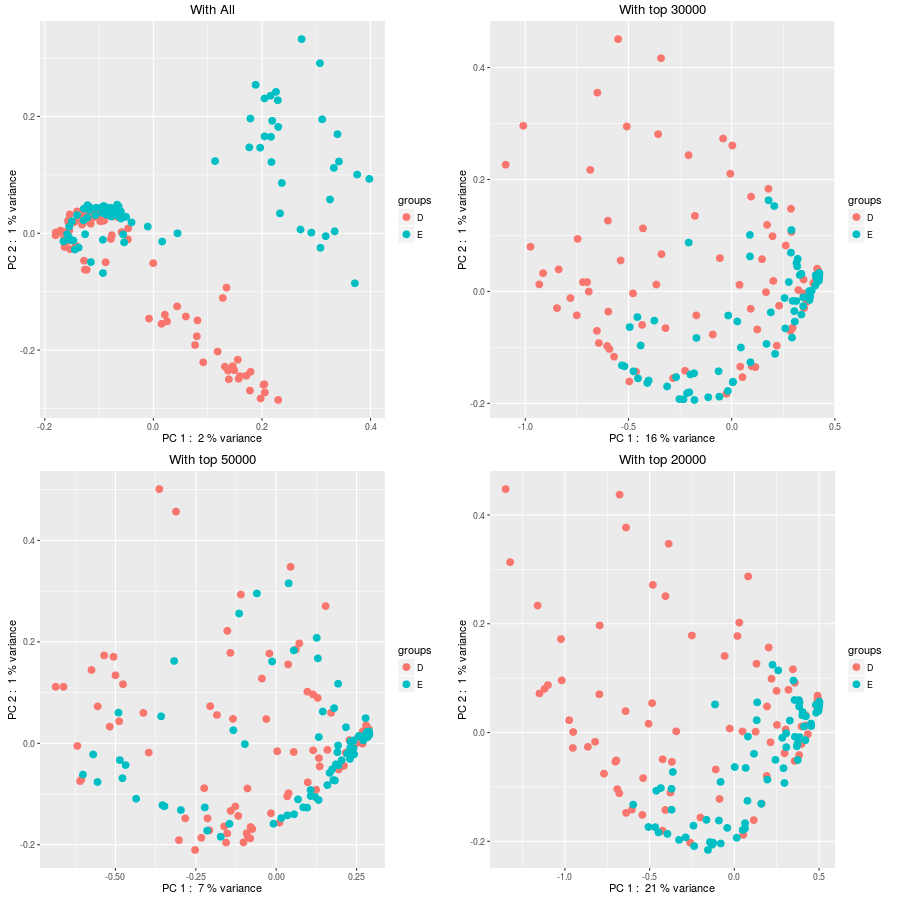

In [24]:
%%R -w 900 -h 900
p1 <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With All")
topX=50000
p2 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 50000")
topX=30000
p3 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 30000")

topX=20000
p4 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 20000")
multiplot(p1,p2,p3,p4,cols=2)

## Now with merge BAM files

In [25]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are. This has to be the folder
# where each of the individual cells peak files reside
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set this parameter to the folder where the peaks for the merge files are. This can be the same folder
# of all the individual cells peak folder or can be a single peak file that is generated from merging BAM files
peakFolderToMerge = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'

# Set the outputPeakFileName name here
outputPeakFileName = 'PeakHitsMergedBam.csv'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + outputPeakFileName


In [26]:
mergePeaks(peakFolderToMerge, peakFilePattern)

In [27]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder,outputPeakFileName
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName)

In [28]:
%%R -w 600 -h 600 -i peakFile
cdFinalMerged <- read.csv(peakFile, header=TRUE)

In [29]:
%%R
sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinalMerged[,4:dim(cdFinalMerged)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinalMerged[,4:dim(cdFinalMerged)[2]]) 
table(sg)

sg
 D  E 
84 89 


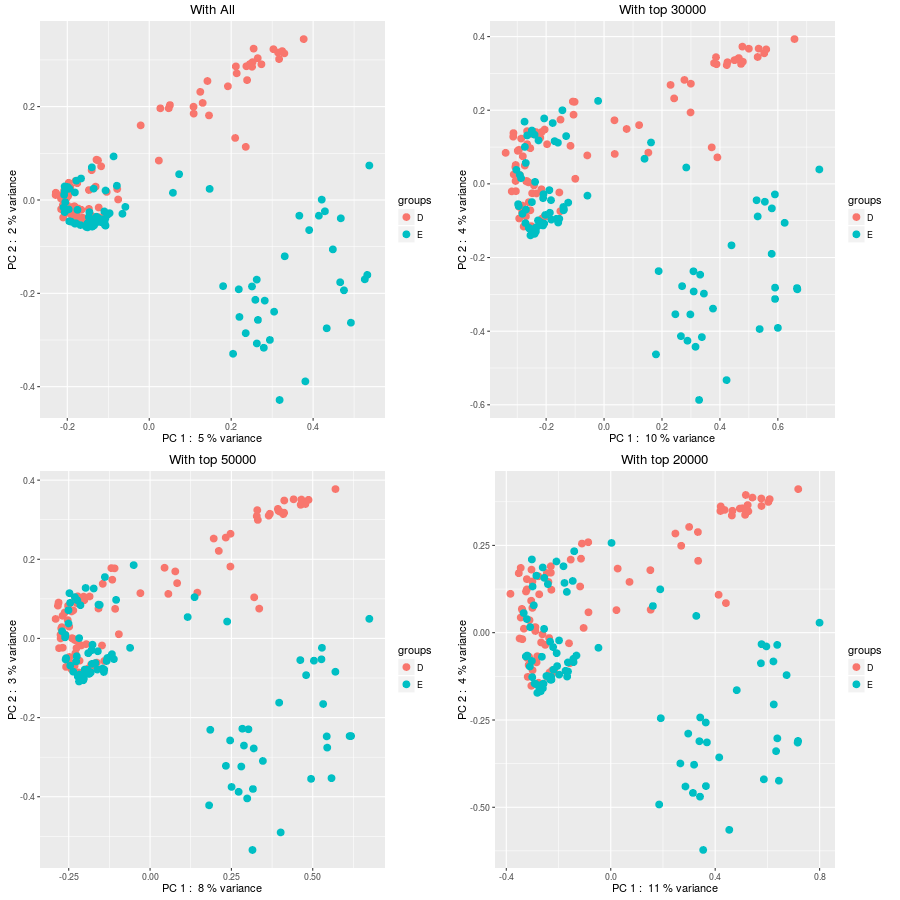

In [31]:
%%R -w 900 -h 900
p5 <- plotPCAJaccard(cdFinalMerged, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With All")
topX=50000
p6 <- plotPCAJaccard(cdFinalMerged[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 50000")
topX=30000
p7 <- plotPCAJaccard(cdFinalMerged[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 30000")

topX=20000
p8 <- plotPCAJaccard(cdFinalMerged[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 20000")
multiplot(p5,p6,p7,p8,cols=2)

In [260]:
! awk '{print $1,$2,$3,$9}' /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/AllFilteredBAM_peaks.narrowPeak > /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/tmpCollapsedBam.txt
! sort -nrk4   /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/tmpCollapsedBam.txt >  /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/collapsed_BAM_peaks.narrowPeak.bed
! rm /home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/tmpCollapsedBam.txt

In [261]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are
peakFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredMacs2Files/'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# Set this file to the merged Peak File
# This file has to have four columns and has to be sorted based on top peaks
mergedPeakFile = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/collapsed_BAM_peaks.narrowPeak.bed'

# Set this folder to where the outputPeakFileName File would be saved
outputFolder = '/home/baker/my-dpsf-scratch-share/Syed_scATAC_and_scRNA_comparison/AllFilteredBAM/'

# Set the outputPeakFileName name here
outputPeakFileName = 'peakHits_NotMerging.csv'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + outputPeakFileName

In [262]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder,outputPeakFileName
peakAccesibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName)

   seqnames     start       end width strand       name
1     chr17  39941327  39944011  2685      * 1458.78394
2     chr17  39808331  39813633  5303      * 1130.86646
3     chr17  39808331  39813633  5303      *  909.59412
4     chr17  39956459  39960338  3880      *  799.92145
5     chr17  37909233  37911996  2764      *  689.36157
6     chr17  39926281  39930567  4287      *  655.76367
7     chr17  37830279  37836075  5797      *  652.97321
8     chr17  39948450  39950823  2374      *  619.64172
9     chr17  37860643  37864814  4172      *  594.80255
10    chr17  37830279  37836075  5797      *  592.04999
11    chr17  37891739  37898087  6349      *  575.57202
12    chr17  37854776  37856859  2084      *  537.38513
13    chr17  37830279  37836075  5797      *  534.67242
14    chr17  37885128  37888485  3358      *  496.86966
15    chr17  37891739  37898087  6349      *  454.10269
16    chr17  37842871  37845681  2811      *  448.79382
17    chr17  37891739  37898087  6349      *  43

In [263]:
%%R -w 600 -h 600 -i peakFile
cdFinal <- read.csv(peakFile, header=TRUE)

In [264]:
%%R
#colnames(cdFinal)

sg <- factor(gsub("(D|E).*", "\\1", colnames(cdFinal[,4:dim(cdFinal)[2]])), levels = c("D", "E"))
# the group factor should be named accordingly
names(sg) <- colnames(cdFinal[,4:dim(cdFinal)[2]]) 
table(sg)

sg
 D  E 
84 89 


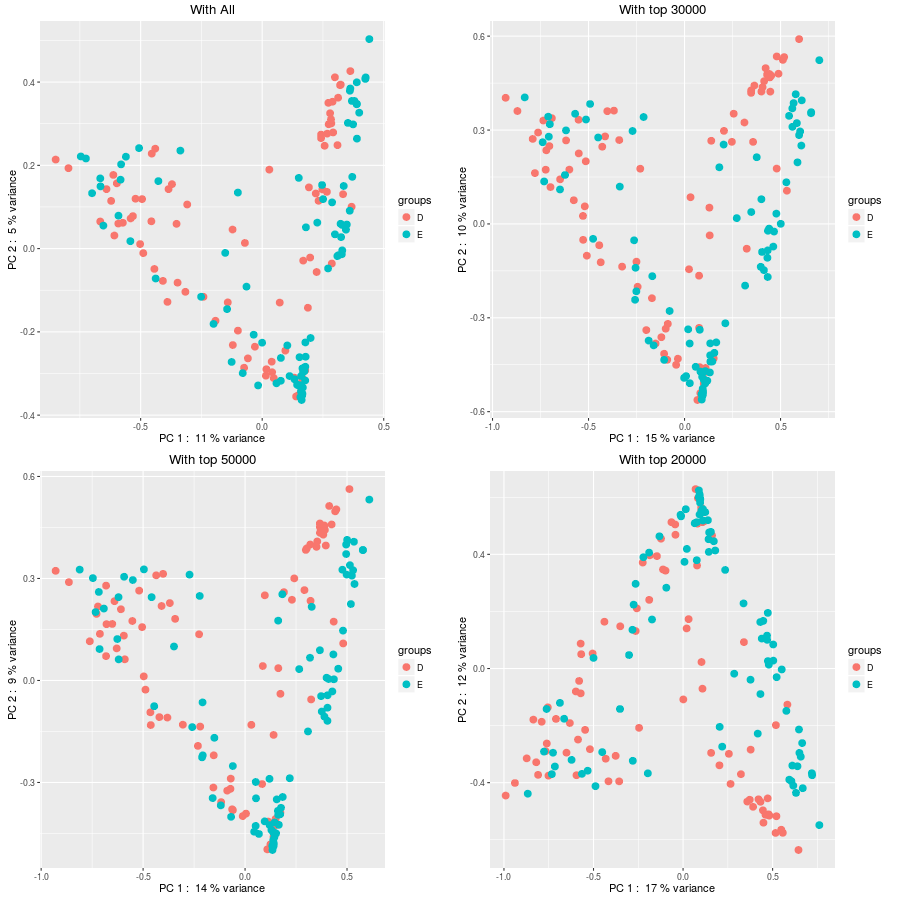

In [265]:
%%R -w 900 -h 900
p1 <- plotPCAJaccard(cdFinal, k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With All")
topX=50000
p2 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 50000")
topX=30000
p3 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 30000")

topX=20000
p4 <- plotPCAJaccard(cdFinal[1:topX,], k=length(levels(sg)), groups=sg, 
                            cell.names=TRUE, ret.val=TRUE, title="With top 20000")
multiplot(p1,p2,p3,p4,cols=2)

## With merged peaks again

## Differential Analysis

In [187]:
%%R
cdDe <- getDiffBind(cdFinal, groups=sg)

In [198]:
%%R
cdDeSorted <- cdDe[order(cdDe$p_adjust, decreasing=FALSE),]
cdDeSorted <- cdDeSorted[cdDeSorted$p_adjust <0.1,]
#cdDeSorted